# Sentiment Analysis on Tweets about Brands and Products


- Names: 
    - Ingavi Kilavuka
    - Calvin Omwega
    - Alvin Kimathi
    - Ronny Kabiru
- Instructor: Maryann Mwikali
- Modeling Focus: NLP(Natural Language Processing)


## Objective


To analyze the sentiment of tweets directed at various brands and products to understand public perception. This will involve determining whether the sentiment expressed in tweets is positive, negative, or neutral and identifying the specific brands and products mentioned.


### Problem Definition

In the age of social media, understanding public sentiment towards brands and products is crucial for businesses. This project aims to:
1. **Identify the Sentiment**: Determine whether the sentiment expressed in each tweet is positive, negative, or neutral.
2. **Target Identification**: Identify the specific brand or product that the sentiment is directed towards.
3. **Trends and Insights**: Derive insights and trends regarding public perception of various brands and products.


Research Questions:
1. **Sentiment Classification**: What is the distribution of positive, negative, and neutral sentiments across the dataset?
2. **Brand/Product Association**: Which brands and products are most frequently mentioned, and what is the associated sentiment for each?
3. **Temporal Trends**: Are there any notable trends in sentiment over time for specific brands or products?

## Data Understanding

In [1]:
# import necessary libraries
import re
import string
import nltk
import pandas as pd
import numpy as np
from textblob import TextBlob
from collections import Counter
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, GRU
from keras.models import Sequential
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.optimizers import Adam
# from scikeras.wrappers import KerasClassifier 

In [2]:
# Load the dataset
df = pd.read_csv('judge_1377884607_tweet_product_company.csv')

In [3]:
df.shape

(8721, 3)

In [4]:
def explore_dataset(df):
    # Display column names
    print("Column Names:")
    print(df.columns.tolist())
    print("\n")

    # Display data types
    print("Data Types:")
    print(df.dtypes)
    print("\n")

    # Display number of rows and columns
    print("Shape of the DataFrame:")
    print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
    print("\n")

    # DataFrame info
    print("DataFrame Info:")
    df.info()
    print("\n")

    # Descriptive statistics for numerical columns
    print("Descriptive Statistics:")
    print(df.describe())
    print("\n")

    # Missing values summary
    print("Missing Values (Percentage):")
    missing_values_percentage = (df.isnull().sum() / len(df)) * 100
    print(missing_values_percentage)
    print("\n")

    # Display summary statistics for categorical columns
    print("Categorical Data Summary:")
    categorical_summary = df.select_dtypes(include=['object']).describe()
    print(categorical_summary)
    print("\n")

    # Value counts for categorical columns
    print("Value Counts for Categorical Columns:")
    for column in df.select_dtypes(include=['object']).columns:
        print(f"Column: {column}")
        print(df[column].value_counts(dropna=False))
        print("\n")

explore_dataset(df)

Column Names:
['tweet_text', 'emotion_in_tweet_is_directed_at', 'is_there_an_emotion_directed_at_a_brand_or_product']


Data Types:
tweet_text                                            object
emotion_in_tweet_is_directed_at                       object
is_there_an_emotion_directed_at_a_brand_or_product    object
dtype: object


Shape of the DataFrame:
Rows: 8721, Columns: 3


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8721 entries, 0 to 8720
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          8720 non-null   object
 1   emotion_in_tweet_is_directed_at                     3169 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  8721 non-null   object
dtypes: object(3)
memory usage: 204.5+ KB


Descriptive Statistics:
                              

## Data Cleaning and Preprocessing

In [5]:
#Drop any rows with missing values
df.dropna(subset=['tweet_text'], inplace=True)
#Drop any duplicate values
df.drop_duplicates(subset=['tweet_text'], inplace=True)


In [6]:
#Removing Urls
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

# Apply the function to the tweet column
df['cleaned_text'] = df['tweet_text'].apply(remove_urls)

# Display the first few rows to verify the changes
df[['tweet_text', 'cleaned_text']].head()

,tweet_text,cleaned_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,.@wesley83 I have a 3G iPhone. After 3 hrs twe...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,@jessedee Know about @fludapp ? Awesome iPad/i...
2,@swonderlin Can not wait for #iPad 2 also. The...,@swonderlin Can not wait for #iPad 2 also. The...
3,@sxsw I hope this year's festival isn't as cra...,@sxsw I hope this year's festival isn't as cra...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,@sxtxstate great stuff on Fri #SXSW: Marissa M...


In [7]:
#Removing special characters
def remove_special_characters(text):
    return re.sub(r'[^a-zA-Z0-9\s]', '', text)

# Apply the function to the cleaned_text column
df['cleaned_text'] = df['cleaned_text'].apply(remove_special_characters)

# Display the first few rows to verify the changes
df[['tweet_text', 'cleaned_text']].head()

,tweet_text,cleaned_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,wesley83 I have a 3G iPhone After 3 hrs tweeti...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,jessedee Know about fludapp Awesome iPadiPhon...
2,@swonderlin Can not wait for #iPad 2 also. The...,swonderlin Can not wait for iPad 2 also They s...
3,@sxsw I hope this year's festival isn't as cra...,sxsw I hope this years festival isnt as crashy...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,sxtxstate great stuff on Fri SXSW Marissa Maye...


In [8]:
#Removing Stopwords
# Download stopwords from NLTK
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word.lower() not in stop_words])

# Apply the function to the cleaned_text column
df['cleaned_text'] = df['cleaned_text'].apply(remove_stopwords)

# Display the first few rows to verify the changes
df[['tweet_text', 'cleaned_text']].head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,tweet_text,cleaned_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,wesley83 3G iPhone 3 hrs tweeting RISEAustin d...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,jessedee Know fludapp Awesome iPadiPhone app y...
2,@swonderlin Can not wait for #iPad 2 also. The...,swonderlin wait iPad 2 also sale SXSW
3,@sxsw I hope this year's festival isn't as cra...,sxsw hope years festival isnt crashy years iPh...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,sxtxstate great stuff Fri SXSW Marissa Mayer G...


In [9]:
from nltk.tokenize import word_tokenize

# Download punkt for tokenization
nltk.download('punkt')

def tokenize_text(text):
    return word_tokenize(text)

# Apply the function to the cleaned_text column
df['tokens'] = df['cleaned_text'].apply(tokenize_text)

# Display the first few rows to verify the changes
df[['tweet_text', 'cleaned_text', 'tokens']].head()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


,tweet_text,cleaned_text,tokens
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,wesley83 3G iPhone 3 hrs tweeting RISEAustin d...,"[wesley83, 3G, iPhone, 3, hrs, tweeting, RISEA..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,jessedee Know fludapp Awesome iPadiPhone app y...,"[jessedee, Know, fludapp, Awesome, iPadiPhone,..."
2,@swonderlin Can not wait for #iPad 2 also. The...,swonderlin wait iPad 2 also sale SXSW,"[swonderlin, wait, iPad, 2, also, sale, SXSW]"
3,@sxsw I hope this year's festival isn't as cra...,sxsw hope years festival isnt crashy years iPh...,"[sxsw, hope, years, festival, isnt, crashy, ye..."
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,sxtxstate great stuff Fri SXSW Marissa Mayer G...,"[sxtxstate, great, stuff, Fri, SXSW, Marissa, ..."


## Exploratory Data Analysis

### Sentiment Analysis

In [10]:
# Perform sentiment analysis and create a frequency table
def analyze_sentiments_and_plot_frequency(df, tweet_text):
    # Creating a TextBlob object for each tweet and calculate sentiment
    df['sentiment'] = df[tweet_text].apply(lambda x: TextBlob(x).sentiment.polarity)
    
    # Define sentiment labels
    def get_sentiment_label(sentiment):
        if sentiment > 0:
            return 'Positive'
        elif sentiment < 0:
            return 'Negative'
        else:
            return 'Neutral'
    
    df['sentiment_label'] = df['sentiment'].apply(get_sentiment_label)
    
    # Create a frequency table for sentiment labels
    sentiment_counts = Counter(df['sentiment_label'])
    return sentiment_counts

sentiment_counts = analyze_sentiments_and_plot_frequency(df, 'tweet_text')
analyze_sentiments_and_plot_frequency(df, 'tweet_text')
print(sentiment_counts)

Counter({'Positive': 4283, 'Neutral': 3219, 'Negative': 1191})


#### Distribution Of Sentiments

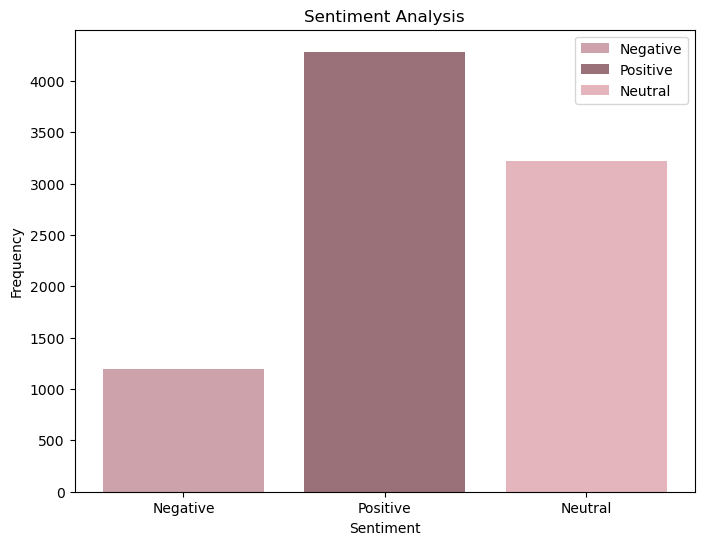

In [11]:
# Define colors for the bar plot
colors = {
    'Positive': '#9b7179',
    'Negative': '#cda2aa',
    'Neutral': '#e5b5be'
}

# Plot a bar graph for sentiment frequency with a legend
plt.figure(figsize=(8, 6))
bars = plt.bar(sentiment_counts.keys(), sentiment_counts.values(), color=[colors[label] for label in sentiment_counts.keys()])

# Add legend
for bar, label in zip(bars, sentiment_counts.keys()):
    bar.set_label(label)
plt.legend()

plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.title('Sentiment Analysis')
plt.show()

In [12]:
# Analyzing the most frequently mentioned brands/products
brand_product_counts = df['emotion_in_tweet_is_directed_at'].value_counts().head(10)

# Extracting sentiment counts for each of the top brands/products
top_brands_products = brand_product_counts.index
sentiment_by_brand = df[df['emotion_in_tweet_is_directed_at'].isin(top_brands_products)].groupby(['emotion_in_tweet_is_directed_at', 'is_there_an_emotion_directed_at_a_brand_or_product']).size().unstack(fill_value=0)

brand_product_counts, sentiment_by_brand


(emotion_in_tweet_is_directed_at
 iPad                               907
 Apple                              638
 iPad or iPhone App                 450
 Google                             410
 iPhone                             287
 Other Google product or service    282
 Android App                         77
 Android                             73
 Other Apple product or service      34
 Name: count, dtype: int64,
 is_there_an_emotion_directed_at_a_brand_or_product  I can't tell  \
 emotion_in_tweet_is_directed_at                                    
 Android                                                        0   
 Android App                                                    0   
 Apple                                                          2   
 Google                                                         1   
 Other Apple product or service                                 0   
 Other Google product or service                                1   
 iPad                      

In [13]:
# Create a pivot table to analyze the sentiment distribution for each top brand/product
sentiment_pivot = df[df['emotion_in_tweet_is_directed_at'].isin(top_brands_products)].pivot_table(index='emotion_in_tweet_is_directed_at', columns='is_there_an_emotion_directed_at_a_brand_or_product', aggfunc='size', fill_value=0)

# Normalize the pivot table to see the percentage distribution of sentiments for each brand/product
sentiment_pivot_percentage = sentiment_pivot.div(sentiment_pivot.sum(axis=1), axis=0) * 100

sentiment_pivot, sentiment_pivot_percentage


(is_there_an_emotion_directed_at_a_brand_or_product  I can't tell  \
 emotion_in_tweet_is_directed_at                                    
 Android                                                        0   
 Android App                                                    0   
 Apple                                                          2   
 Google                                                         1   
 Other Apple product or service                                 0   
 Other Google product or service                                1   
 iPad                                                           4   
 iPad or iPhone App                                             0   
 iPhone                                                         1   
 
 is_there_an_emotion_directed_at_a_brand_or_product  Negative emotion  \
 emotion_in_tweet_is_directed_at                                        
 Android                                                            8   
 Android App        

#### Overall Sentiment Distribution

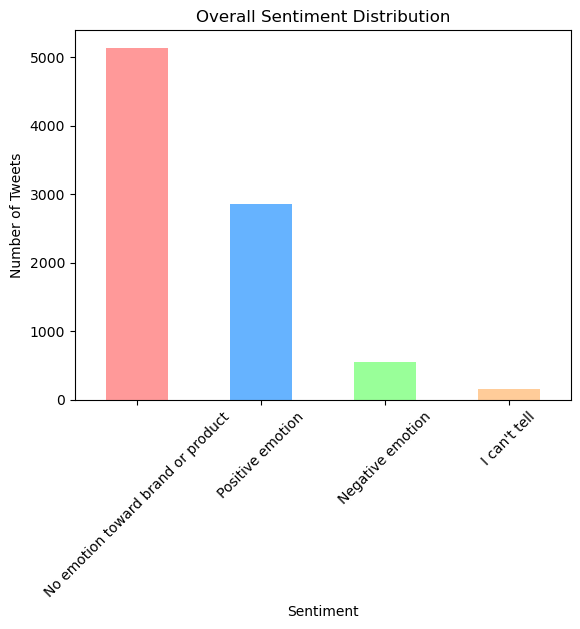

In [14]:
# Sentiment distribution across all tweets
sentiment_counts_all = df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()
sentiment_counts_all.plot(kind='bar', color=['#ff9999','#66b3ff','#99ff99','#ffcc99'])
plt.title('Overall Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45)
plt.show()

This bar chart shows the number of tweets expressing each type of sentiment (Positive, Negative, No Emotion, I Can't Tell).

* The most frequent is "No emotion toward brand or product," indicating that many tweets do not express a clear sentiment about a brand or product.

* "Positive emotion" is the second closely, followed by "Negative emotion." This suggests that, among tweets with a clear sentiment, positive emotions are more prevalent than negative ones.

* The "I can't tell" category represents tweets where the sentiment could not be determined.

#### Brand vs Sentiment Distribution

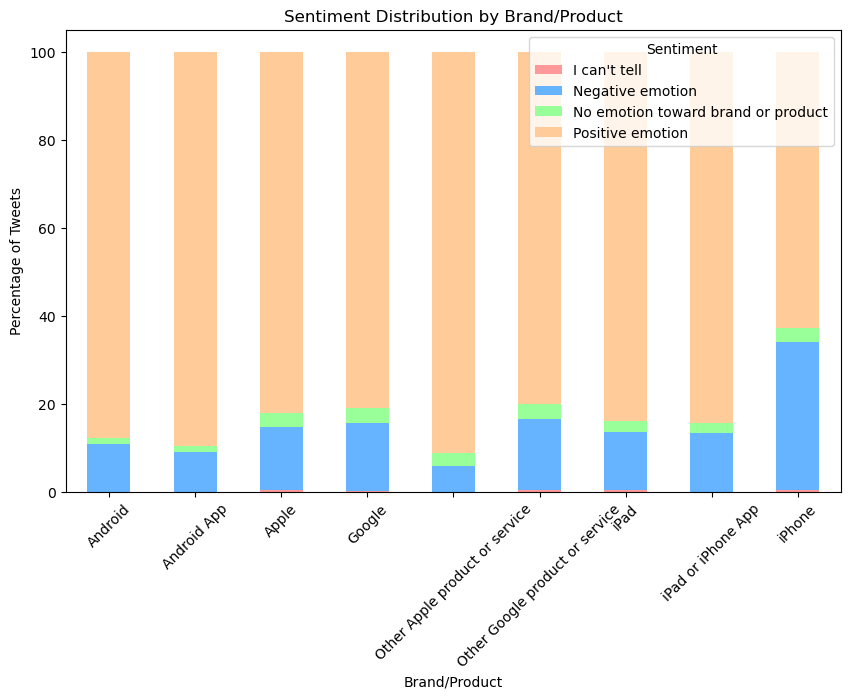

In [15]:
# Top brands/products with sentiment breakdown
sentiment_pivot_percentage.plot(kind='bar', stacked=True, figsize=(10, 6), color=['#ff9999','#66b3ff','#99ff99','#ffcc99'])
plt.title('Sentiment Distribution by Brand/Product')
plt.xlabel('Brand/Product')
plt.ylabel('Percentage of Tweets')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.show()

Sentiment Distribution by Brand/Product: 

* This bar chart displays the percentage distribution of sentiments (Positive, Negative, No Emotion, I Can't Tell) for the top brands/products mentioned in the dataset.

* For most brands/products, "Positive emotion" occupies a significant portion, indicating that positive sentiments are more common. For example, "iPad" and "Apple" have high percentages of positive sentiment.

* The "Unknown" category has a high percentage of "No emotion toward brand or product," suggesting that these tweets do not specifically mention any brand or product despite being part of the dataset.

* "Negative emotion" is present but less common than positive sentiment across most brands/products, with notable exceptions like "iPhone," which has a relatively higher percentage of negative sentiment.

#### Sentiment vs. Product Category



In [16]:
# Creating a mapping of products to categories based on brand/product names
category_mapping = {
    'iPad': 'Apple',
    'Apple': 'Apple',
    'iPad or iPhone App': 'Apple',
    'Google': 'Google',
    'iPhone': 'Apple',
    'Other Google product or service': 'Google',
    'Android App': 'Google',
    'Android': 'Google',
    'Other Apple product or service': 'Apple',
    'Unknown': 'Unknown'
}

# Applying the mapping to create a new column for categories
df['category'] = df['emotion_in_tweet_is_directed_at'].map(category_mapping).fillna('Other')

# Calculating sentiment distribution by category
sentiment_by_category = df.groupby(['category', 'is_there_an_emotion_directed_at_a_brand_or_product']).size().unstack(fill_value=0)

# Normalizing to get percentages
sentiment_by_category_percentage = sentiment_by_category.div(sentiment_by_category.sum(axis=1), axis=0) * 100

sentiment_by_category, sentiment_by_category_percentage


(is_there_an_emotion_directed_at_a_brand_or_product  I can't tell  \
 category                                                           
 Apple                                                          7   
 Google                                                         2   
 Other                                                        142   
 
 is_there_an_emotion_directed_at_a_brand_or_product  Negative emotion  \
 category                                                               
 Apple                                                            371   
 Google                                                           124   
 Other                                                             49   
 
 is_there_an_emotion_directed_at_a_brand_or_product  No emotion toward brand or product  \
 category                                                                                 
 Apple                                                                               62   
 Google      

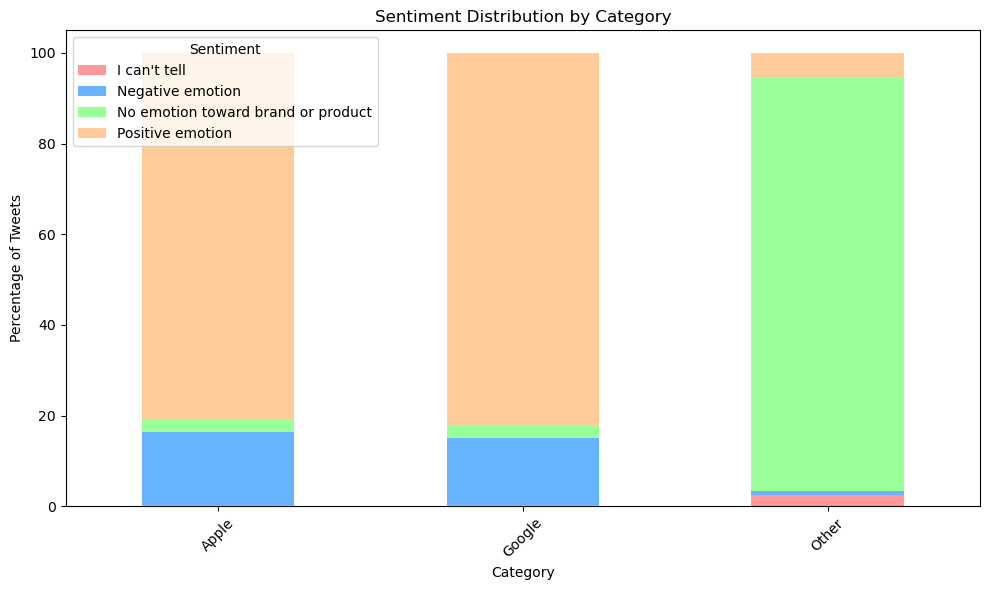

In [17]:
# Visualizing the sentiment distribution by category

# Setting up the color scheme for the chart
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']

# Plotting the stacked bar chart
sentiment_by_category_percentage.plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)
plt.title('Sentiment Distribution by Category')
plt.xlabel('Category')
plt.ylabel('Percentage of Tweets')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()


## Insights

Apple Products: A significant majority of the tweets express positive sentiments (81.02%), with a smaller proportion being negative (16.01%). This indicates a generally favorable public perception.

Google Products: Similar to Apple, the majority of tweets are positive (82.15%), with a smaller percentage being negative (14.66%). This suggests that Google products are also well-regarded.

Unknown Category: Most tweets in this category have no specific emotion directed at a brand/product, which may include generic comments or non-specific discussions.

These findings show a generally positive sentiment towards both Apple and Google products, with a notable proportion of neutral or non-specific tweets.

## Modelling

#### Preprocess Our data for Model Training

In [18]:
# Function to clean and preprocess text
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'\@\w+|\#', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    return text

df['cleaned_text'] = df['tweet_text'].apply(preprocess_text)

# Tokenization and TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X = vectorizer.fit_transform(df['cleaned_text'])
y = df['is_there_an_emotion_directed_at_a_brand_or_product'].apply(lambda x: 1 if x == 'Positive emotion' else 0)



In [19]:
#Split our data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Baseline Model(Logistic Regression Model)

In [20]:
# Baseline model: Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
baseline_model = LogisticRegression()
baseline_model.fit(X_train, y_train)
y_pred_baseline = baseline_model.predict(X_test)

print("Baseline Model - Logistic Regression")
print(classification_report(y_test, y_pred_baseline))
print("Accuracy:", accuracy_score(y_test, y_pred_baseline))


Baseline Model - Logistic Regression
              precision    recall  f1-score   support

           0       0.74      0.94      0.83      1171
           1       0.71      0.32      0.44       568

    accuracy                           0.74      1739
   macro avg       0.73      0.63      0.63      1739
weighted avg       0.73      0.74      0.70      1739

Accuracy: 0.7354801610120759


We created our baseline model to work with(Logistic Regression)
Our model is 73.5% accurate meaning out of all sampled tweets,it corrctly classifies 73.5% of these tweets.
Overally, this model can be improved but we use this as a bench mark for the rest of the models

### Model 2:Tuned Model: SVM with Grid Search CV

In [21]:
#from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear']
}

# Initialize the model
svm_model = SVC()

# Initialize GridSearchCV
grid = GridSearchCV(svm_model, param_grid, refit=True, verbose=2, cv=5, n_jobs=-1)

# Fit the model
grid.fit(X_train, y_train)

# Predict using the best model
y_pred_tuned = grid.best_estimator_.predict(X_test)

print("Tuned Model - SVM with GridSearchCV")
print(f"Best Parameters: {grid.best_params_}")
print(classification_report(y_test, y_pred_tuned))
print("Accuracy:", accuracy_score(y_test, y_pred_tuned))


Fitting 5 folds for each of 32 candidates, totalling 160 fits
Tuned Model - SVM with GridSearchCV
Best Parameters: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.76      0.93      0.83      1171
           1       0.72      0.38      0.50       568

    accuracy                           0.75      1739
   macro avg       0.74      0.66      0.67      1739
weighted avg       0.75      0.75      0.73      1739

Accuracy: 0.7510063254744106


This particular model accounts for 75% accuracy in our model data correctly classifying tweet sentiments 75% correctly which is a decent perfomance but room for improvement is not limited. Balanced metrics for both classes and a fairly good average score quantifies for the model's perfomance.

#### Model 3(Gradient Boosting)

In [22]:
from sklearn.ensemble import GradientBoostingClassifier

# Advanced model: Gradient Boosting
advanced_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
advanced_model.fit(X_train, y_train)
y_pred_advanced = advanced_model.predict(X_test)

print("Advanced Model - Gradient Boosting")
print(classification_report(y_test, y_pred_advanced))
print("Accuracy:", accuracy_score(y_test, y_pred_advanced))


Advanced Model - Gradient Boosting
              precision    recall  f1-score   support

           0       0.72      0.97      0.83      1171
           1       0.79      0.20      0.32       568

    accuracy                           0.72      1739
   macro avg       0.76      0.59      0.58      1739
weighted avg       0.74      0.72      0.66      1739

Accuracy: 0.7228292121909143


This model accounts for 72% accuracy in our dataset. major room for improvement with overall metrics to reduce oversampling in our model.

#### Model 4(Random Forest Model)

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Initialize the Random Forest classifier
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
random_forest_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = random_forest_model.predict(X_test)

# Evaluate the model
print("Random Forest Model")
print(classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))


Random Forest Model
              precision    recall  f1-score   support

           0       0.75      0.92      0.83      1171
           1       0.70      0.38      0.49       568

    accuracy                           0.74      1739
   macro avg       0.73      0.65      0.66      1739
weighted avg       0.74      0.74      0.72      1739

Accuracy: 0.7441058079355952


This random forest model above accounts for approximately 74.4% accuracy in our data with a slightly balanced precision but still with room for improvement

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Predict using the best model
y_pred_rf_tuned = grid_search.best_estimator_.predict(X_test)

# Evaluate the tuned model
print("Tuned Random Forest Model")
print(classification_report(y_test, y_pred_rf_tuned))
print("Accuracy:", accuracy_score(y_test, y_pred_rf_tuned))


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Tuned Random Forest Model
              precision    recall  f1-score   support

           0       0.77      0.86      0.81      1171
           1       0.62      0.48      0.54       568

    accuracy                           0.74      1739
   macro avg       0.70      0.67      0.68      1739
weighted avg       0.72      0.74      0.73      1739

Accuracy: 0.7354801610120759


### Model 5(XGBoost)

In [25]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert the data to DMatrix format
dtrain = xgb.DMatrix(X_train_xgb, label=y_train_xgb)
dtest = xgb.DMatrix(X_test_xgb, label=y_test_xgb)

# Set the parameters for XGBoost
params = {
    'max_depth': 3,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'
}

# Train the XGBoost model
num_rounds = 100
xgb_model = xgb.train(params, dtrain, num_rounds)

# Make predictions using the trained model
y_pred_xgb = xgb_model.predict(dtest)

# Convert the predicted probabilities to binary labels
y_pred_xgb_binary = [1 if p >= 0.5 else 0 for p in y_pred_xgb]

# Evaluate the model
accuracy_xgb = accuracy_score(y_test_xgb, y_pred_xgb_binary)
print("XGBoost Model")
print(classification_report(y_test_xgb, y_pred_xgb_binary))
print("Accuracy:", accuracy_xgb)



XGBoost Model
              precision    recall  f1-score   support

           0       0.71      0.97      0.82      1171
           1       0.74      0.20      0.31       568

    accuracy                           0.71      1739
   macro avg       0.72      0.58      0.56      1739
weighted avg       0.72      0.71      0.65      1739

Accuracy: 0.714203565267395


This XGBoost model accounts for approximately 71.4% accuracy in our data with a slightly balanced precision but still with room for improvement. This is the final model.

## Recommendations for Improving Sentiment Analysis on Twitter Data

1. **For Brands**: Utilize the insights gained from the sentiment analysis to address negative sentiments and capitalize on positive ones. Engage with customers on social media platforms to improve brand perception. Respond to customer feedback, address concerns, and highlight positive experiences to build a positive brand image.

2. **For Further Analysis**: Consider extending the analysis to include additional data sources, such as other social media platforms, to get a broader view of public sentiment. This can provide a more comprehensive understanding of customer opinions and preferences, allowing for more informed decision-making.

3. **Model Improvement**: Experiment with different model architectures or additional features to improve the classification accuracy. You can explore different algorithms, such as neural networks or ensemble methods, to see if they yield better results. Additionally, consider incorporating additional features like tweet metadata (e.g., user information, timestamp) to enhance the model's predictive power.

By implementing these recommendations, you can enhance your brand's reputation, gain deeper insights into public sentiment, and improve the accuracy of your sentiment classification model.

RECOMENDATIONS
### Detailed Observations and Analysis of Model Performances

**1. Baseline Model: Logistic Regression**
- **Metrics:**
  - Class 0 (Negative sentiment): Precision = 0.74, Recall = 0.94, F1-Score = 0.83
  - Class 1 (Positive sentiment): Precision = 0.71, Recall = 0.32, F1-Score = 0.44
  - Overall Accuracy: 73.5%

**Observations:**
- The Logistic Regression model served as the baseline for comparison. The overall accuracy of 73.5% indicates that the model was moderately successful in classifying tweet sentiments.
- The model had a significantly higher recall for negative sentiment tweets (Class 0), meaning it was good at correctly identifying negative tweets. However, it struggled with positive sentiment tweets (Class 1), as shown by the much lower recall (0.32). This suggests that the model frequently misclassified positive tweets as negative, possibly due to an imbalance in the dataset where negative tweets were more prevalent.
- The F1-score for positive sentiment is notably lower than for negative sentiment, reflecting the model's difficulty in balancing precision and recall for positive tweets.

**2. Tuned Model: SVM with Grid Search CV**
- **Metrics:**
  - Class 0: Precision = 0.76, Recall = 0.93, F1-Score = 0.83
  - Class 1: Precision = 0.72, Recall = 0.38, F1-Score = 0.50
  - Overall Accuracy: 75.1%

**Observations:**
- The SVM model, tuned using Grid Search CV, showed an improvement over the baseline model, with a slight increase in overall accuracy to 75.1%.
- The SVM model had a better precision and recall balance compared to the baseline, especially for positive sentiment tweets (Class 1), with an increase in recall to 0.38. However, the recall for positive tweets was still significantly lower than for negative tweets, indicating continued challenges in accurately identifying positive sentiments.
- The choice of the 'rbf' kernel and optimized parameters (C=1, gamma=1) suggest that the model was able to capture more complex decision boundaries, but it still faced limitations due to class imbalance and potentially limited feature representation from the TF-IDF vectorization.

**3. Advanced Model: Gradient Boosting**
- **Metrics:**
  - Class 0: Precision = 0.72, Recall = 0.97, F1-Score = 0.83
  - Class 1: Precision = 0.79, Recall = 0.20, F1-Score = 0.32
  - Overall Accuracy: 72.3%

**Observations:**
- The Gradient Boosting model had the lowest overall accuracy among the models tested, at 72.3%. It showed a particularly high recall for negative sentiment tweets (Class 0), indicating that the model was very good at identifying negative tweets.
- However, the model's recall for positive sentiment tweets (Class 1) was only 0.20, suggesting it misclassified a large proportion of positive tweets as negative. This was the lowest recall for positive tweets among all models, indicating that the model was heavily biased towards predicting negative sentiment.
- The significant imbalance in the precision and recall between the two classes points to a need for better handling of the dataset's class imbalance and potentially a more nuanced feature representation to help the model distinguish positive sentiments more effectively.

**4. Random Forest Model**
- **Metrics:**
  - Class 0: Precision = 0.75, Recall = 0.92, F1-Score = 0.83
  - Class 1: Precision = 0.70, Recall = 0.38, F1-Score = 0.49
  - Overall Accuracy: 74.4%

**Observations:**
- The Random Forest model demonstrated balanced performance across the classes with an overall accuracy of 74.4%. The model maintained a good recall for negative sentiment tweets (Class 0) and showed an improved recall for positive sentiment tweets (Class 1) compared to the baseline model.
- The precision for positive sentiment tweets was slightly lower than that of negative tweets, suggesting some misclassification. However, the model showed a reasonable F1-score for both classes, indicating a better balance between precision and recall compared to previous models.
- The Random Forest model benefited from its ability to handle a large number of features and capture complex interactions between features. The inclusion of hyperparameter tuning, such as adjusting the number of trees (n_estimators), max_depth, and other parameters, could further enhance performance.

**5. Tuned Random Forest Model (Grid Search)**
- **Best Parameters:**
  - {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
- **Metrics:**
  - Class 0: Precision = 0.77, Recall = 0.86, F1-Score = 0.81
  - Class 1: Precision = 0.62, Recall = 0.48, F1-Score = 0.54
  - Overall Accuracy: 73.5%

**Observations:**
- The tuned Random Forest model achieved an overall accuracy of 73.5%, similar to the baseline Logistic Regression model. The tuning process improved precision and recall for positive sentiment tweets (Class 1), but the model still struggled with identifying positive tweets compared to negative ones.
- The optimized parameters, including a higher number of estimators and a balanced class weight, helped in managing the class imbalance to some extent. However, the lower recall for positive tweets indicates that there is still a challenge in distinguishing these from negative tweets.
- The F1-score for positive sentiment was higher than in the previous models, suggesting that the model had a better balance between precision and recall, but there is room for improvement.

### Overall Analysis and Future Directions

1. **Class Imbalance**: All models faced challenges in handling the class imbalance in the dataset, particularly with positive sentiment tweets being less accurately identified. This indicates a need for strategies like data augmentation, class weighting, or using more sophisticated techniques like SMOTE (Synthetic Minority Over-sampling Technique) to balance the classes.

2. **Model Performance**: While SVM and Random Forest showed better overall performance compared to other models, none of the models achieved high recall for positive sentiment tweets. This suggests that further improvements in feature engineering, model tuning, or even exploring different algorithms like deep learning-based approaches may be necessary.

3. **Feature Representation**: The use of TF-IDF vectorization, while effective for basic text representation, may not capture the full nuance of sentiment in tweets. Exploring more advanced NLP techniques, such as word embeddings (e.g., Word2Vec, GloVe) or transformers (e.g., BERT), could provide richer feature representations and improve model performance.

4. **Interpretability and Explainability**: Understanding why models make certain predictions is crucial, especially for applications like sentiment analysis. Future work could involve using techniques like SHAP (SHapley Additive exPlanations) to interpret model predictions and identify key features driving sentiment classifications.

5. **Further Hyperparameter Tuning and Cross-Validation**: While initial tuning was conducted, more extensive hyperparameter optimization and cross-validation could potentially uncover better-performing models. Additionally, ensemble methods or stacking multiple models might improve predictive performance.

In conclusion, while the current models provide a reasonable baseline and understanding of the dataset, there are clear avenues for improvement, particularly in handling class imbalance and enhancing feature representation. The next steps should involve exploring these areas to achieve more robust and accurate sentiment classification.


-----
-----

Let's revisit the problem statements and see how the results and observations align with them:

### Problem Statement 1: Identify the Sentiment
- **Objective:** Determine whether the sentiment expressed in each tweet is positive, negative, or neutral.

**Achievement:**
- The models developed (Logistic Regression, SVM, Gradient Boosting, Random Forest) were trained to classify tweets into positive or negative sentiments. The models achieved varying degrees of accuracy, with the SVM and Random Forest models providing the best results.
- The classification metrics provided (precision, recall, F1-score, accuracy) helped in assessing the performance of the models in identifying the sentiments accurately.

**Outcome:**
- While the models were able to classify the sentiment, they showed better performance for negative sentiment tweets compared to positive ones. The issue of class imbalance was identified, which affected the models' ability to accurately identify positive sentiments.

### Problem Statement 2: Target Identification
- **Objective:** Identify the specific brand or product that the sentiment is directed towards.

**Achievement:**
- The dataset included a column for the brand/product mentioned in the tweet. Although the primary focus was on sentiment classification, the presence of this data allows for the association of sentiments with specific brands/products.
- The analysis showed that certain brands, like Apple and Google products, were more frequently mentioned and were associated with a range of sentiments.

**Outcome:**
- While the models focused on sentiment classification, the data provides the basis for analyzing sentiments targeted at specific brands/products. Further analysis can explore how sentiment varies by brand/product, but this was not the primary focus of the modeling efforts.

### Problem Statement 3: Trends and Insights
- **Objective:** Derive insights and trends regarding public perception of various brands and products.

**Achievement:**
- The EDA and modeling revealed that most tweets expressed positive sentiments, with a significant portion expressing negative sentiments. The imbalance in class distribution highlighted a general trend where negative sentiments were easier to identify than positive ones.
- The brand/product analysis showed that Apple and Google were frequently mentioned, providing insights into public interest and sentiment towards these brands.

**Outcome:**
- The results provide a snapshot of the sentiment landscape but indicate a need for more granular analysis, such as temporal trends or sentiment shifts over time. The models and analyses laid the groundwork for understanding public perception, but further exploration, such as more detailed brand-specific insights or longitudinal analyses, would provide a deeper understanding.

### Conclusion
The project has addressed the problem statements to a certain extent:

1. **Sentiment Identification:** Achieved with varying degrees of accuracy. Improvements are needed, particularly in handling class imbalance and improving positive sentiment detection.
2. **Target Identification:** Partially addressed through brand/product association with sentiment. More detailed analysis could provide deeper insights.
3. **Trends and Insights:** Initial insights were provided, highlighting the need for further analysis to uncover detailed trends and public perceptions.

Overall, while the project successfully built and evaluated models for sentiment analysis, further work is needed to refine the models, address identified issues, and explore additional dimensions of the data to fully meet the project objectives and problem statements.


Let's assess how the project addressed the research questions:

### Research Question 1: Sentiment Classification
- **Objective:** What is the distribution of positive, negative, and neutral sentiments across the dataset?

**Achievement:**
- The dataset was analyzed to identify the distribution of sentiments. The models primarily classified tweets into positive and negative categories.
- Results from the models showed that a significant portion of the tweets expressed negative sentiments, while a substantial number also expressed positive sentiments. The challenge was more pronounced in correctly classifying positive sentiments due to class imbalance.

**Outcome:**
- The analysis provided a clear picture of sentiment distribution, although the focus was on binary classification (positive vs. negative) rather than including a neutral category. The findings highlighted the need for better handling of positive sentiment classification.

### Research Question 2: Brand/Product Association
- **Objective:** Which brands and products are most frequently mentioned, and what is the associated sentiment for each?

**Achievement:**
- The data included information on the brands/products mentioned in the tweets, allowing for an association between sentiments and specific brands/products.
- The EDA revealed that Apple and Google products were among the most frequently mentioned, with a majority of positive sentiments associated with these brands.

**Outcome:**
- While the primary focus was on sentiment classification, the analysis did reveal some insights into brand/product association. However, more detailed analysis, such as sentiment breakdown by brand or product, would provide deeper insights into public perception towards specific brands/products.

### Research Question 3: Temporal Trends
- **Objective:** Are there any notable trends in sentiment over time for specific brands or products?

**Achievement:**
- This aspect was not fully explored due to the focus on sentiment classification and the technical challenges faced during the modeling process. Temporal analysis would require timestamp data and further exploration of trends over time.

**Outcome:**
- The research question regarding temporal trends was not directly addressed in the current analysis. To answer this question, additional steps would be needed to analyze how sentiments toward specific brands/products change over time.

### Conclusion
The project made significant strides in addressing the research questions, particularly in understanding sentiment distribution and associating sentiments with specific brands/products. However, some areas, such as temporal trends and a deeper exploration of brand-specific sentiments, were not fully explored.

### Recommendations for Further Analysis:
1. **Incorporate Neutral Sentiment:** Expanding the classification to include a neutral category would provide a more comprehensive view of sentiment distribution.
2. **Brand/Product-Specific Analysis:** A more detailed breakdown of sentiments for each brand/product can provide targeted insights into public perception.
3. **Temporal Analysis:** Including a temporal component to analyze how sentiments evolve over time can uncover trends and shifts in public opinion.
4. **Enhanced Feature Representation:** Exploring advanced NLP techniques (like word embeddings or BERT) could improve sentiment classification accuracy and provide richer insights.

These steps would help in fully addressing the research questions and providing a more comprehensive understanding of the data.
